![](./images/JN_header.jpg)

# On Shaky Ground
---
**Author:**  [Ted Brandon](https://github.com/theobigdog)

## Introduction
---
Most everyone, even those who don't live in prone areas, knows about earthquakes and the devastating damage they can cause, with caveats of landslides, liquifaction and tsunami.  All of these aspects, combined, form a great threat to human lives, as well as infrastucture, dwellings, businesses, all other structures, etc.,...  On March 11, 2011, a M-9.0 earthquake off the east coast of Japan caused a tsunami that not only wreaked havoc, as described above, but also led to one of the worst nuclear catastrophies the world has seen.  Estimated death count for this event is ~20,000 with an estimation of \\$220 billion USD in damages in Japan alone.  On December 26, 2004, a M-9.1 earthquake off the coast of Sumatra-Andaman caused a tsunami that hit all nearby islands and most nearby countries, including Indonesia, Sri Lanka, India, Maldives and Thailand.  This earthquake resulted in the loss of at least 225,000 human beings, and damages of ~\\$15 billion USD.  January 12, 2010, a M-7.0 earthquake in Haiti caused such excessive damage to person and property that the country has still not recovered.

Formed in 2009, The Earthquake Disaster Assistance Team (EDAT) is an international rapid response team under the USGS umbrella.

## Data Understanding
---
blah blah balh

In [1]:
# Import the goodies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

Load data into a df, combine `Date` and `Time` to make a new feature, which can then be converted to a "date-time" object.

In [2]:
df = pd.read_csv('data/Significant_Earthquakes_1965-2016.csv')

df['Date_Time'] = df['Date'] + ' ' + df['Time']
df_dt = df.drop('Date', axis=1).drop('Time', axis=1)
dt = df_dt['Date_Time']
df_dt.drop('Date_Time', axis=1, inplace=True)
df_dt = pd.concat([dt, df_dt], axis=1)

#Rows 3378, 7512, 20650 have date-times in a different format, so we'll drop them.
df_dt.drop([3378,7512,20650], inplace=True)

df_dt['Date_Time'] = pd.to_datetime(df_dt['Date_Time'])
df_dt.reset_index(drop=True)
df_dt.head(1)

,Date_Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,1965-01-02 13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic


## Start the EDA process

In [5]:
#dropping all entries that are not actual Earthquakes (no Nuclear Explosions, Explosions or Rock Bursts)
df_eq = df_dt[df_dt['Type'] == 'Earthquake'].reset_index(drop=True)

Multiple columns are missing too much data, so I will drop them here, "Type" is dropped because
all entries are "Earthquake" due to the way the data have thus far been processed.

In [6]:
drop_cols = ['Type','Depth Error','Depth Seismic Stations','Magnitude Error','Magnitude Seismic Stations','Azimuthal Gap',\
            'Horizontal Distance','Horizontal Error','Root Mean Square']
df_trim = df_eq.drop(drop_cols, axis=1)

Trim categorical columns to 50 entries minimum per entry type

In [27]:
magtype = ['MW','MWC','MB','MWB','MWW','MS','ML']
source = ['US','ISCGEM','ISCGEMSUP','GCMT','NC']
locsrc = ['US','ISCGEM','GCMT','NC']
magsrc = ['US','HRV','ISCGEM','GCMT','NC']

df_trunc = df_trim[df_trim['Magnitude Type'].isin(magtype)]
df_trunc = df_trunc[df_trunc['Source'].isin(source)]
df_trunc = df_trunc[df_trunc['Location Source'].isin(locsrc)]
df_trunc = df_trunc[df_trunc['Magnitude Source'].isin(magsrc)]
df_trunc = df_trunc.reset_index(drop=True)

23412 entries to start.  Now that this has been cleaned up extensively, we have dropped down
to 22820 entries.  This is a loss of 592 entries, or 2.5%.

## Earthquake Map

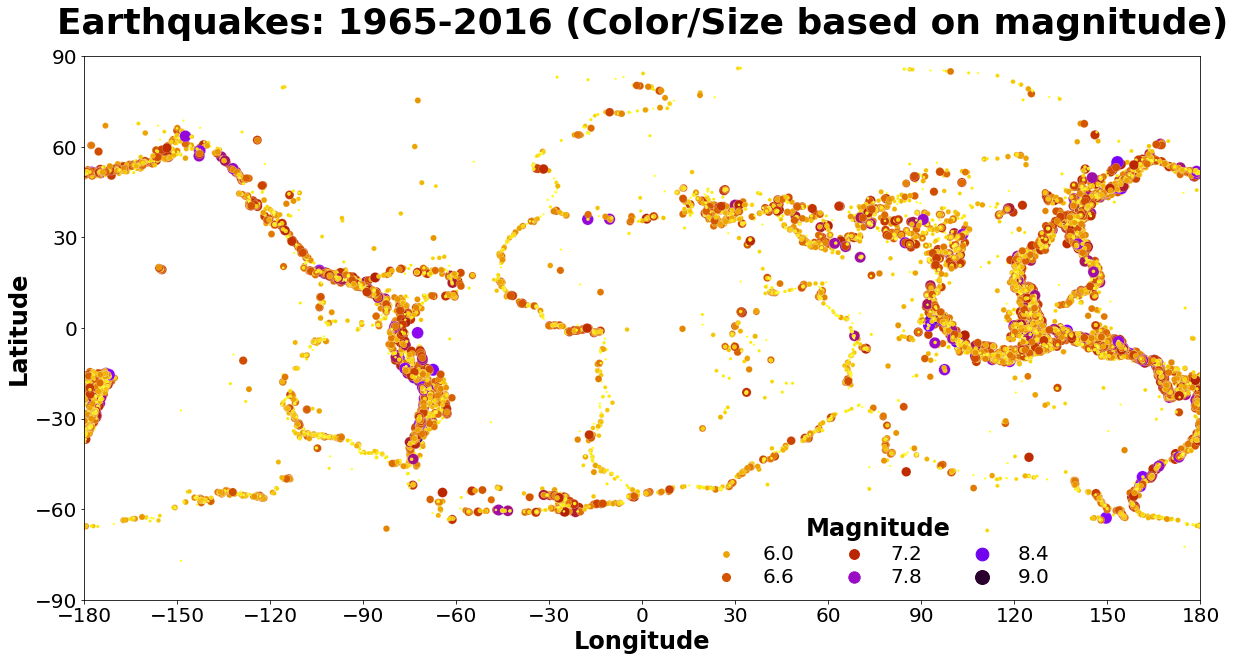

In [12]:
lat_30 = [-90,-60,-30,0,30,60,90]
long_30 = [-180,-150,-120,-90,-60,-30,0,30,60,90,120,150,180]

fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x=df_trunc['Longitude'], y=df_trunc['Latitude'], hue=df_trunc['Magnitude'],
                size=df_trunc['Magnitude'], sizes=(5,200),marker='o',palette='gnuplot_r')
# leg_col = '#f7f7f7' # For overlay
leg_col = 'black' # For notebook
legend = plt.legend(title='Magnitude', title_fontsize=24, fontsize=20, labelspacing=0.2,
                loc=(0.55,0.01), ncol=3, frameon=False, labelcolor=leg_col)
plt.setp(legend.get_title(), color =leg_col, fontweight='bold')
ax.set_ylim([-90,90])
plt.title('Earthquakes: 1965-2016 (Color/Size based on magnitude)', fontsize=36,
          fontweight='bold', y=1.03)
plt.xlabel('Longitude', fontsize=24, fontweight='bold')
plt.yticks(lat_30, fontsize=20)
ax.set_xlim([-180,180])
plt.ylabel('Latitude', fontsize=24, fontweight='bold')
plt.xticks(ticks=(long_30), fontsize=20);
# plt.savefig('images/earthquake_map_presentation.png', transparent=True, dpi=300) # Export for presentation
# plt.savefig('images/earthquake_map_notebook.png', dpi=300) # Export for notebook

## Feature Engineering

I want to see if binning this by month or season will provide useful information.

In [13]:
df_binned = df_trunc.copy()
df_binned['Month'] = pd.DatetimeIndex(df_binned['Date_Time']).month

season = {1 : 'Winter', 2 : 'Winter', 3 : 'Spring', 4 : 'Spring', 5 : 'Spring', 6 : 'Summer',
         7 : 'Summer', 8 : 'Summer', 9 : 'Fall', 10 : 'Fall', 11 : 'Fall', 12 : 'Winter'}

df_binned['Season'] = df_binned['Month'].map(season)

## Country names were generated, based on Lats/Longs

Since I will eventually pare this down to just Asian countries, the next few blocks of code were written to identify the country that experienced a given earthquake.  The first step used `Latitude` and `Longitude` and `reverseGeocode` to generate a `Country` column.  The entries in this column are long, single strings of information which needed to be trimmed to recover the country codes ("cc").

The `reverseGeocode` step took about 4hr to complete, so these intermediate results were backed-up as a csv.  The `country_converter` function took a while as well, so these converted results were separately backed-up.  The final saved csv allows for these time-demanding steps to be bypassed in the future.

In [14]:
# This was only used once to create the final csv.  Do not use again

# #!pip install reverse_geocoder
# import reverse_geocoder as rg
# from pandas import DataFrame

# def reverseGeocode(coordinates):
#     return rg.search(coordinates)

# df_countries = df_magn.copy()
# df_countries['Country'] = df_countries['Lat_Long'].apply(reverseGeocode)

# df_countries.to_csv('data/df_countries.csv')

# #!pip install country_converter
# import country_converter as coco

# def get_cc (info_string : str) -> str:
#     cc_pre = (info_string.split("'cc': '",1)[1])
#     cc = cc_pre[:-3]
#     return cc

# def convert_cc (cc : str) -> str:
#     name = coco.convert(names=cc, to='name_short')
#     return name

# df_countries['Country_Code'] = df_countries['Country'].apply(get_cc)

# df_countries['Country'] = df_countries['Country_Code'].apply(convert_cc)

# df_countries.to_csv('data/fixed_countries.csv')

### A new df, containing appropriate country names was then imported

In [15]:
df_countries = pd.read_csv('data/fixed_countries.csv')

Going to need latitude/longitude in list-form, down the line

In [18]:
lat_long = []
for i in range(len(df_countries['Latitude'])):
    lat_long.append([round(df_countries['Latitude'][i],3), round(df_countries['Longitude'][i],3)])
df_countries['Lat_Long'] = lat_long

### Now we can identify each earthquake as occurring in asia, by using the following function to check for presence in the following [list of asian countries](https://www.countries-ofthe-world.com/countries-of-asia.html):

In [19]:
def is_asian(country):
    asia = ['Afghanistan','Armernia','Azerbaijan','Bahrain','Bangladesh','Bhutan','Brunei',
           'Cambodia','China','Cyprus','Georgia','India','Indonesia','Iran','Irag','Israel',
           'Japan','Jordan','Kazakhstan','Kuwait','Kyrgyzstan','Laos','Lebanon','Malaysia',
           'Maldives','Mongolia','Myanmar','Nepal','North Korea','Oman','Pakistan','Palestine',
           'Philippines','Qatar','Russia','Saudi Arabia','Singapore','South Korea','Sri Lanka',
           'Syria','Taiwan','Tajikistan','Thailand','Timor-Leste','Turkey','Turkmenistan','UAE',
           'United Arab Emirates','United Arab Emirates (UAE)','Uzbekistan','Vietnam','Yemen']
    if country in asia:
        asian = 1
    else:
        asian = 0
    return asian

df_countries['In_Asia'] = df_countries['Country'].apply(is_asian)

In [35]:
total_earthquakes = len(df_countries)
asian_earthquakes = df_countries['In_Asia'].value_counts()[1]
non_asian_earthquakes = df_countries['In_Asia'].value_counts()[0]
percent_asian = round(df_countries['In_Asia'].value_counts('1')[1] * 100, 2)

print('There are ' + str(total_earthquakes) + ' earthquakes in the initial data set.')
print(str(asian_earthquakes) + ' of these occurred in Asian countries,')
print('leaving ' + str(non_asian_earthquakes) + ' occurring in the rest of the world.')
print('This means that earthquakes in Asia accounted for ' + str(percent_asian) + '% of the\
 world total from 1965 through 2016.')

There are 22820 earthquakes in the initial data set.
8804 of these occurred in Asian countries,
leaving 14016 occurring in the rest of the world.
This means that earthquakes in Asia accounted for 38.58% of the world total from 1965 through 2016.


In [21]:
df_asian = df_countries[df_countries['In_Asia'] == 1].reset_index(drop=True)

In [22]:
#  Oops!  Extra indices from the two "big" engineered features.  Dropping:

drop_indices = ['Unnamed: 0','Unnamed: 0.1']
df_asian = df_asian.drop(drop_indices, axis=1)

### Plot of Asian Earthquakes

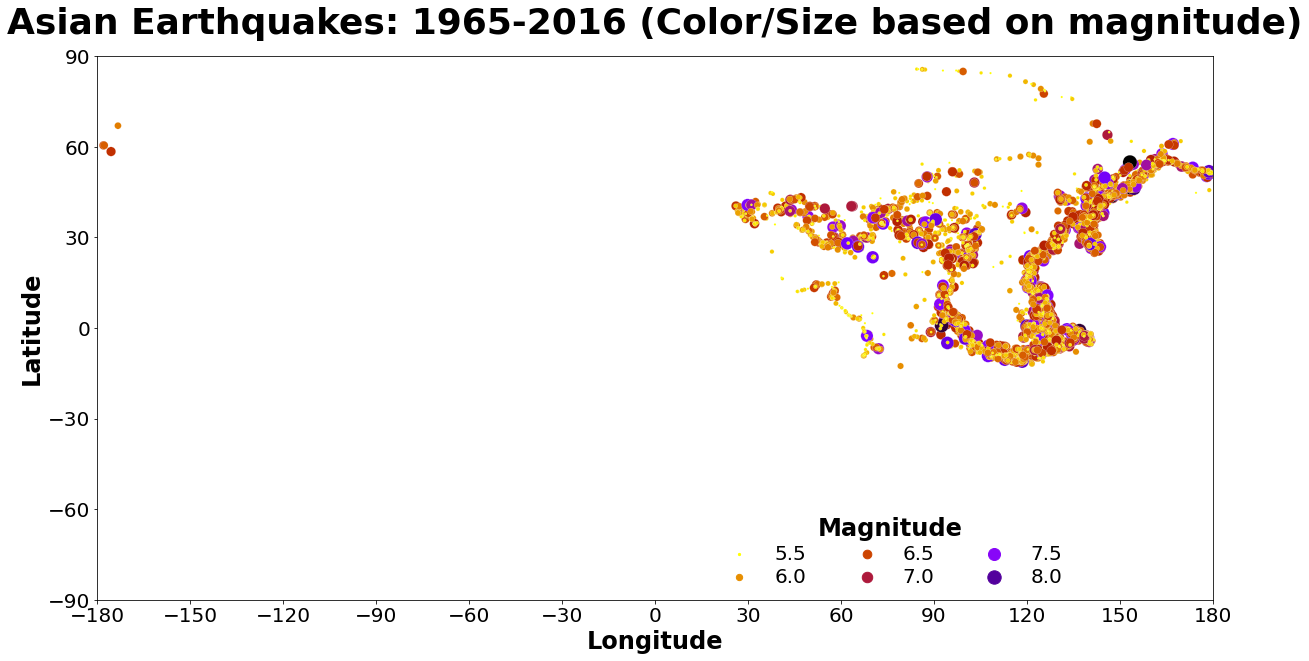

In [23]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x=df_asian['Longitude'], y=df_asian['Latitude'], hue=df_asian['Magnitude'],
                size=df_asian['Magnitude'], sizes=(5,200),marker='o',palette='gnuplot_r')
# leg_col = '#f7f7f7' # For overlay
leg_col = 'black' # For notebook
legend = plt.legend(title='Magnitude', title_fontsize=24, fontsize=20, labelspacing=0.2,
                loc=(0.55,0.01), ncol=3, frameon=False, labelcolor=leg_col)
plt.setp(legend.get_title(), color =leg_col, fontweight='bold')
ax.set_ylim([-90,90])
plt.title('Asian Earthquakes: 1965-2016 (Color/Size based on magnitude)', fontsize=36,
          fontweight='bold', y=1.03)
plt.xlabel('Longitude', fontsize=24, fontweight='bold')
plt.yticks(lat_30, fontsize=20)
ax.set_xlim([-180,180])
plt.ylabel('Latitude', fontsize=24, fontweight='bold')
plt.xticks(ticks=(long_30), fontsize=20);
# plt.savefig('images/asian_earthquake_map_presentation.png', transparent=True, dpi=300) # Export for presentation
# plt.savefig('images/asian_earthquake_map_notebook.png', dpi=300) # Export for notebook

In [24]:
This is about where I stopped cleaning up the notebook 11/30/2021

SyntaxError: invalid syntax (<ipython-input-24-d21f15354659>, line 1)

Somehow, the Date_Time column was re-converted to "object" so I'll fix that now:

In [ ]:
df_asian['Date_Time'] = pd.to_datetime(df_asian['Date_Time']).reset_index(drop=True)

In [ ]:
# Going to look at all points together, instead of binning the magnitude ranges, per Max

asian_ts = pd.Series(df_asian.set_index(df_asian['Date_Time'])['Magnitude'])

# And now we'll resample to Monthly sum and see how it looks

monthly_sum_asian = asian_ts.resample('M').sum()

# We'll make a Monthly mean now too for funsies

monthly_mean_asian = asian_ts.resample('M').mean()


In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(17,6), tight_layout=True)

ax = axs[0]
monthly_sum_asian.plot(ax=ax)
ax=axs[1]
monthly_mean_asian.plot(ax=ax);

#### Dickey-Fuller

In [ ]:
from statsmodels.tsa.stattools import adfuller

def run_df(ts):
    df_rslt = adfuller(ts)
    print("Dickey_Fuller test results:  \n")
    df_output = pd.Series(df_rslt[0:4], index=['Test Statistic','p-value',\
                                              '#Lags Used','Number of Observations Used'])
    for key, value in df_rslt[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)

In [ ]:
run_df(asian_ts)

In [ ]:
# Let's do the same thing now, but with the data resampled as "Daily"

daily_sum_asian = asian_ts.resample('D').sum()

daily_mean_asian = asian_ts.resample('D').mean()

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(17,6), tight_layout=True)

ax=axs[0]

daily_sum_asian.plot(ax=ax)
ax.set_title('Daily Sum of Asian Earthquakes Over Time')
ax=axs[1]
daily_mean_asian.plot(ax=ax)
ax.set_title('Daily Mean of Asian Earthquakes Over Time');

In [ ]:
# and now "weekly"

weekly_sum_asian = asian_ts.resample('W').sum()

weekly_mean_asian = asian_ts.resample('W').mean()

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(17,6), tight_layout=True)

ax=axs[0]

weekly_sum_asian.plot(ax=ax)
ax.set_title('Weekly Sum of Asian Earthquakes Over Time')
ax=axs[1]
weekly_mean_asian.plot(ax=ax)
ax.set_title('Weekly Mean of Asian Earthquakes Over Time');

### Let's do a train/test split on the weekly mean data:

In the case of time series, a random sampling of test samples is not going to work, so we'll just take the most recent 20% as the test, and the older 80% as the train

In [ ]:
cutoff = round(weekly_mean_asian.shape[0] * 0.8)

In [ ]:
train = weekly_mean_asian[:cutoff]
test = weekly_mean_asian[cutoff:]

In [ ]:
fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.set_title('Train/Test Split');

# First Simple Model (FSM) => Random Walk

In [ ]:
# The "shift" operator predicts where the next point (week) will be
random_walk = train.shift(1)

In [ ]:
# plot the Random Walk:

fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='blue', label='original')
random_walk[0:30].plot(ax=ax, c='orange', label='shifted')
ax.set_title('FSM => Random Walk')
ax.legend();

For a baseline to compare with future models, the RMSE will be needed:

In [ ]:
np.sqrt(mean_squared_error(train.dropna()[1:], random_walk.dropna()))

RMSE calculated a different way, in order to plot residuals:

In [ ]:
residuals = random_walk[1:] - train[1:]
mse = (residuals**2).sum()/len(residuals-1)
np.sqrt(mse)

In [ ]:
# plotting residuals:

fig, ax = plt.subplots()

ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(52).std());

In [ ]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

In [ ]:
# Differenced data (more like white noise):

fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Weekly differenced data');

# Trying a "second" FSM with monthly means instead of weekly

In [ ]:
monthly_mean_asian = asian_ts.resample('MS').mean()

In [ ]:
cutoff = round(monthly_mean_asian.shape[0] * 0.8)

In [ ]:
train = monthly_mean_asian[:cutoff]
test = monthly_mean_asian[cutoff:]

In [ ]:
print(monthly_mean_asian.mean())
print(monthly_mean_asian.std())
print(train.mean())
print(train.std())
print(test.mean())
print(test.std())

In [ ]:
sns.histplot(train, bins=10);

In [ ]:
sns.histplot(test, bins=10);

In [ ]:
fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.set_title('Train/Test Split');

In [ ]:
train

In [ ]:
random_walk = train.shift(1)

In [ ]:
fig, ax = plt.subplots()

train[0:50].plot(ax=ax, c='blue', label='original')
random_walk[0:50].plot(ax=ax, c='orange', label='shifted')
ax.set_title('FSM => Random Walk')
ax.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))

train[0:50].plot(ax=ax, c='blue', label='Original')
random_walk[0:50].plot(ax=ax, c='orange', label='Assisted')
ax.set_title('Earthquake "Prediction" on a Monthly Basis\n"Random Walk"', fontsize=36)
plt.ylabel('Earthquake Magnitude', fontsize=30)
plt.yticks(fontsize=24)
plt.xlabel('')
plt.xticks(fontsize=24)
ax.legend(fontsize=28,loc='lower right');
plt.savefig('images/random_walk.png', dpi=300)

In [ ]:
np.sqrt(mean_squared_error(train.dropna()[1:], random_walk.dropna()))

In [ ]:
residuals = random_walk[1:] - train[1:]
mse = (residuals**2).sum()/len(residuals-1)
np.sqrt(mse)

In [ ]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(12).std());

In [ ]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

In [ ]:
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Monthly differenced data');

# ARIMA
##### AR:  The prediction that today will be like previous days, with statsmodels object "p"
##### MA:  Moving average, accounts for short-run autocorrelation, with statsmodels object "q"
             "q" can be estimated from ACF plots

In [ ]:
# Using Monthly data here (train2)

ar_1 = ARIMA(train, order=(1,1,0)).fit()
ar_1.predict(typ='levels')

In [ ]:
ar_1.summary()

In [ ]:
ar_1.aic

In [ ]:
random_walk_model = ARIMA(train, order=(0,1,0)).fit()
random_walk_model.summary()

In [ ]:
print(f'Random Walk AIC:  {random_walk_model.aic}')
print(f'AR(1,1,0) AIC: {ar_1.aic}')

In [ ]:
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

In [ ]:
y_hat_rw = random_walk_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_rw))

In [ ]:
ar_1.arparams

In [ ]:
lr = LinearRegression()
lr.fit(np.array(train.diff().shift(1).dropna()).reshape(-1,1), train[1:].diff().dropna())
print(lr.coef_)

In [ ]:
ar_2 = ARIMA(train, order=(2,1,0)).fit()
ar_2.predict(typ='levels')

In [ ]:
y_hat_ar2 = ar_2.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar2))

In [ ]:
print(f'AR(2,1,0) AIC: {ar_2.aic}')

In [ ]:
ma_1 = ARIMA(train, order=(0,0,1)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat

In [ ]:
ma_1.summary()

In [ ]:
ma_1 = ARIMA(train, order=(0,1,1)).fit()

print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)

In [ ]:
y_hat_ma1 = ma_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ma1))

In [ ]:
ma_2 = ARIMA(train, order=(0,1,2)).fit()
y_hat = ma_2.predict(typ='levels')

In [ ]:
y_hat_ma2 = ma_2.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ma2))

In [ ]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)

In [ ]:
arma_21 = ARIMA(train, order=(2,1,2)).fit()

In [ ]:
y_hat_arma21 = arma_21.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_arma21))

In [ ]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)
print(arma_21.aic)

## ACF and PACF

In [ ]:
plot_pacf(train.diff().dropna());

In [ ]:
df = pd.DataFrame(train)
df.columns = ['lag_0']
df['lag_1'] = train.shift()
df.head()

In [ ]:
gamma_1 = sum(((df['lag_0'][1:]-df['lag_0'][1:].mean()) *\
               (df['lag_1'].dropna()-df['lag_1'].dropna().mean())))/(len(df['lag_1'])-1)
gamma_1

In [ ]:
rho = gamma_1/(df.lag_0[1:].std(ddof=0)*df.lag_1.std(ddof=0))
rho

In [ ]:
df = pd.DataFrame(train)
df.columns = ['lag_0']
df['lag_1'] = train.shift()
df['lag_2'] = train.shift(2)
df['lag_3'] = train.shift(3)
df['lag_4'] = train.shift(4)
df['lag_5'] = train.shift(5)
df.corr()

In [ ]:
list(df.corr()['lag_0'].index)
plt.bar(list(df.corr()['lag_0'].index), list(df.corr()['lag_0']));

In [ ]:
plot_acf(train);

In [ ]:
plot_acf(train.diff().dropna());

In [ ]:
aa_model = ARIMA(train, order=(0, 1, 1)).fit()
y_hat_train = aa_model.predict(typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_train)
ax.plot(train);

In [ ]:
fig, ax = plt.subplots()
ax.plot(y_hat_train[50:70])
ax.plot(train[50:70]);

In [ ]:
aa_model.summary()

In [ ]:
test

In [ ]:
y_hat_test = aa_model.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_test);

In [ ]:
fig, ax = plt.subplots()
ax.plot(y_hat_test)
ax.plot(test)
ax.legend(labels = ['Predicted','Actual']);

In [ ]:
np.sqrt(mean_squared_error(test, y_hat_test))

In [ ]:
plot_acf(monthly_mean_asian);

In [ ]:
plot_acf(monthly_mean_asian, lags=75)

In [ ]:
# p = d = q = range(0, 3)
# pdq = list(itertools.product(p, [1], q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# print('Examples of parameters for SARIMA...')
# for i in pdq:  ##  Only turn on when optimizing
#     for s in seasonal_pdq:
#         print('SARIMAX: {} x {}'.format(i, s))

In [ ]:
# for param in pdq:  # Only run again if we need to re-optimize
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod=SARIMAX(train,
#                          order=param,
#                          seasonal_order=param_seasonal,
#                          enforce_stationarity=False,
#                          enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             print('Oops!')
#             continue

In [ ]:
sari_mod =SARIMAX(train,
                  order=(0,1,1),
                  seasonal_order=(0, 1, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [ ]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train, label='Train')
ax.plot(test, label='Test')
ax.plot(y_hat_train, label='Train Predicted')
ax.plot(y_hat_test, label='Test Predicted')

plt.legend();

In [ ]:
fig, ax = plt.subplots()

ax.plot(test, label='Actual')
ax.plot(y_hat_test, label='Predicted')

plt.legend();

In [ ]:
def binning(time_series):
    Magn = {'<6':0,'>=6,<6.5':0,'>=6.5,<7':0,'>=7,<7.5':0,'>=7.5':0}
    for entry in time_series:
        if entry < 6:
            Magn['<6'] += 1
        elif entry >= 6 and entry < 6.5:
            Magn['>=6,<6.5'] += 1
        elif entry >=6.5 and entry < 7:
            Magn['>=6.5,<7'] += 1
        elif entry >= 7 and entry < 7.5:
            Magn['>=7,<7.5'] += 1
        else:
            Magn['>=7.5'] += 1
    return Magn
train_breakdown = binning(train)
test_breakdown = binning(test)
train_len = len(train)
test_len = len(test)
for magn_range in train_breakdown:
    print("Train " + str(magn_range) + ':  ' + str(train_breakdown[magn_range]) + ', ' + str(round((train_breakdown[magn_range]/train_len*100),2)) + "%")
print()
for magn_range in test_breakdown:
    print("Test " + str(magn_range) + ':  ' + str(test_breakdown[magn_range]) + ', ' + str(round((test_breakdown[magn_range]/test_len*100),2)) + "%")

In [ ]:
train

In [ ]:
np.sqrt(mean_squared_error(train,y_hat_train))

In [ ]:
np.sqrt(mean_squared_error(test, y_hat_test))

In [ ]:
sari_mod = SARIMAX(monthly_mean_asian,
                  order=(0, 1, 1),
                  seasonal_order=(0, 0, 0, 12), #was 0,1,1
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [ ]:
forecast = sari_mod.forecast(steps=24)

In [ ]:
fig, ax = plt.subplots()

ax.plot(monthly_mean_asian, label='Historical')
ax.plot(forecast, label='Forecast')
ax.set_title('Earthquakes in Asia Predictions\n Two Years Out')

plt.legend();

## Trying a SARIMAX to hopefully introduce Lat/Long/Depth into the mix, rather than just Magnitude

In [ ]:
# Setting up the different Series
monthly_lat = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Latitude'])).resample('MS').mean()
monthly_long = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Longitude'])).resample('MS').mean()
monthly_dep = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Depth'])).resample('MS').mean()

In [ ]:
# Endogenous and Exogenous Variables:
endo = monthly_mean_asian # Magnitude
exo_lat = monthly_lat
exo_long = monthly_long
exo_dep = monthly_dep

In [ ]:
# Fitting the models

mod_lat = SARIMAX(endo, exo_lat,
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_long = SARIMAX(endo, exo_long,
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_dep = SARIMAX(endo, exo_dep,
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_lat_long = SARIMAX(exo_lat, exo_long, # exo_lat is the "endo" for this model
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

In [ ]:
print(mod_lat.summary())

In [ ]:
print(mod_long.summary())

In [ ]:
print(mod_dep.summary())

In [ ]:
print(mod_lat_long.summary())

Trying the forecasting using the template from Amber's JN does not work with these exogenous variable models

In [ ]:
# forecast_lat = mod_lat.forecast(steps=24)
# forecast_long = mod_long.forecast(steps=24)
# forecast_dep = mode_dep.forecast(steps=24)

Generate list of parameters to test for each SARIMAX model (Magnitude with either Latitude, Longitude or Depth.

In [ ]:
'''This was only run once to optimize.  Only uncomment if reoptimization necessary'''
# p = d = q = range(0, 3) # this was a 2 and there was no "d" # Only run once to optimize
# pdq = list(itertools.product(p, d, q)) # "d" was "[1]"
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] #"d" was "[1]"
# print('Examples of parameters for SARIMA...')
# for i in pdq:  ##  Only turn on when optimizing
#     for s in seasonal_pdq:
#         print('SARIMAX: {} x {}'.format(i, s))

Finding Optimal SARIMAX parameters for endo='Magnitude', exo = 'Latitude'

In [ ]:
'''This was only run once to optimize.  Only uncomment if reoptimization necessary
Optimized was (0,1,1),(0,0,0,12) -> aic = -712.00'''
# for param in pdq:  # Only run again if we need to re-optimize - Best is (0,1,1),(0,0,0,12), aic= -712.00
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod=SARIMAX(endo, exo_lat,
#                          order=param,
#                          seasonal_order=param_seasonal,
#                          enforce_stationarity=False,
#                          enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             print('Oops!')
#             continue

Finding Optimal SARIMAX parameters for endo='Magnitude', exo = 'Longitude'

In [ ]:
'''This was only run once to optimize.  Only uncomment if reoptimization necessary
Optimized was (0,1,1),(0,0,0,12) -> aic = -712.59'''
# for param in pdq:  # Only run again if we need to re-optimize - Best is (0,1,1),(0,0,0,12), aic= -712.59
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod=SARIMAX(endo, exo_long,
#                          order=param,
#                          seasonal_order=param_seasonal,
#                          enforce_stationarity=False,
#                          enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             print('Oops!')
#             continue

Finding Optimal SARIMAX parameters for endo='Magnitude', exo = 'Depth'

In [ ]:
'''This was only run once to optimize.  Only uncomment if reoptimization necessary
Optimized was (0,1,1),(0,0,0,12) -> aic = -707.65'''
# for param in pdq:  # Only run again if we need to re-optimize - Best is (0,1,1),(0,0,0,12), aic=-707.65
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod=SARIMAX(endo, exo_dep,
#                          order=param,
#                          seasonal_order=param_seasonal,
#                          enforce_stationarity=False,
#                          enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             print('Oops!')
#             continue

### Trying to make a model that uses Magnitude as the endogenous variable, with Latitude and Longitude as combined exogenous variables.  Might add Depth if that becomes a possibility as well, and time permits.

In [ ]:
'''
Using info from the following link:
https://stackoverflow.com/questions/44212127/how-do-i-input-multiple-exogenous-variables-into-a-sarimax-model-in-statsmodel
to attempt multi-exogenous variable models.

It has you define the exogenous input as an array with dimensions nobsxk, where nobs = # observations
(ie, how many lines in the time-series data) and k is the number of additional exogenous variables.

'''
# nobs = len(endo)
# k = 2 # for adding lat and long
# emp = np.empty([nobs, k])
# arr = np.append(emp, np.array([[exo_lat][0], [exo_long][0]]).transpose(), axis=1)

# arr2 = np.array([[exo_lat][0], [exo_long][0]]).transpose()

# print(emp)
# print(len(emp))
# print(arr)
# print(len(arr))
# print(exo_lat[0],[exo_long[0]])
# print(len(exo_lat))
# print(arr2)
# print(len(endo))



# I don't think I can use monthly means for this, because Latitude and Longitude ranges over a month account for many earthquakes in different parts of asia.  I think the best I can do is use daily means instead.  This still will be prone to a certain amount of error (if there are two earthquakes on the same day in different parts of asia), but we'll just have to deal with that because this is the best I know how to do for now.

## Doing this for all of Asia is appearing to be very slow for the "grid search" process, so I will try just Japan and see how that goes.

In [ ]:
df_japan = df_countries[df_countries['Country'] == 'Japan'].reset_index(drop=True)
df_japan = df_japan.drop(drop_indices, axis=1)
df_japan['Date_Time'] = pd.to_datetime(df_japan['Date_Time']).reset_index(drop=True)
print(len(df_japan))

### Toggle the cell below to use Japan data only (make sure to un-toggle the subsequent Markdown cell)

In [ ]:
# Setting up the different Series
# daily_magn = (pd.Series(df_japan.set_index(df_japan['Date_Time'])['Magnitude'])).resample('D').mean()
# daily_lat = (pd.Series(df_japan.set_index(df_japan['Date_Time'])['Latitude'])).resample('D').mean()
# daily_long = (pd.Series(df_japan.set_index(df_japan['Date_Time'])['Longitude'])).resample('D').mean()
# daily_dep = (pd.Series(df_japan.set_index(df_japan['Date_Time'])['Depth'])).resample('D').mean()

### Toggle the cell below to use all Asia data (make sure to un-toggle the previous Markdown cell)

In [ ]:
daily_magn = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Magnitude'])).resample('D').mean()
daily_lat = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Latitude'])).resample('D').mean()
daily_long = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Longitude'])).resample('D').mean()
daily_dep = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Depth'])).resample('D').mean()

In [ ]:
endo = daily_magn.dropna().reset_index(drop=True)
exo_lat = daily_lat.dropna().reset_index(drop=True)
exo_long = daily_long.dropna().reset_index(drop=True)
exo_dep = daily_dep.dropna().reset_index(drop=True)

In [ ]:
# Fitting the models

mod = SARIMAX(endo,
              order=(0,1,1,),
              seasonal_order=(0,0,0,12),
              enforce_stationarity=False,
              enforce_invertibility=False).fit()

mod_lat = SARIMAX(endo, exo_lat,
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_long = SARIMAX(endo, exo_long,
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_dep = SARIMAX(endo, exo_dep,
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_lat_long = SARIMAX(exo_lat, exo_long, # exo_lat is the "endo" for this model
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

In [ ]:
mod_list = [mod,mod_lat,mod_long,mod_dep,mod_lat_long]

In [ ]:
for model in mod_list:
    print(model.summary())

In [ ]:
lat_long_array = np.array([[exo_lat][0], [exo_long][0]]).transpose()

In [ ]:
'''This was only run once to optimize.  Only uncomment if reoptimization necessary'''
# p = d = q = range(0, 3)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(0, 0, 0, 365)]
# print('Examples of parameters for SARIMA...')
# for i in pdq:
#     for s in seasonal_pdq:
#         print('SARIMAX: {} x {}'.format(i, s))

In [ ]:
'''This was only run once to optimize.  Only uncomment if reoptimization necessary
Optimized was (2,1,2),(0,0,0,365) -> aic = 4796.09'''
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod=SARIMAX(endo, lat_long_array,
#                          order=param,
#                          #seasonal_order=param_seasonal,
#                          enforce_stationarity=False,
#                          enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             print('Oops!')
#             continue

### The best AIC score was for (2,1,2) x (0,0,0,365) => 4796.09
#### Compared to the worst score for (0,0,0) x (0,0,0,365) => 21006.36

In [ ]:
mod_lat_long = SARIMAX(endo, lat_long_array,
                       order = (2,1,2),
                       seasonal_order = (0,0,0,365),
                       enforce_stationarity=False,
                       enforce_invertibility=False).fit()

In [ ]:
print(mod_lat_long.summary())

In [ ]:
mod_lat_long_alt = SARIMAX(endo, lat_long_array,
                       order = (0,1,1),
                       seasonal_order = (0,0,0,365),
                       enforce_stationarity=False,
                       enforce_invertibility=False).fit()

print(mod_lat_long_alt.summary())

In [ ]:
# New Train/Test:

daily_mean_asian = daily_magn
cutoff = round(daily_mean_asian.shape[0] * 0.8)

In [ ]:
train = daily_mean_asian[:cutoff]
test = daily_mean_asian[cutoff:]

In [ ]:
fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.set_ylim(4,8)
ax.set_title('Train/Test Split')

In [ ]:
arimax_mod = SARIMAX(train,
                    order=(2,1,2),
                    seasonal_order=(0,0,0,365),
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit()

In [ ]:
arima_mod = SARIMAX(train,
                   order=(0,1,1),
                   seasonal_order=(0,0,0,365),
                   enforce_stationarity=False,
                   enforce_invertibility=False).fit()

In [ ]:
print(arimax_mod.summary())

Removing the contribution of Latitude/Longitude from the model produces an AIC about 1000 lower than the model which includes them.  The p-value also improve significantly:

In [ ]:
print(arima_mod.summary())

So maybe this is the way to go?

We will continue with the location-adjusted model for now, but we will revisit the above if necessary.

In [ ]:
y_hat_train = arimax_mod.predict(typ='levels')
y_hat_test = arimax_mod.predict(start=test.index[0], end=test.index[-1], typ='levels')

In [ ]:
fig, ax = plt.subplots()
ax.plot(train, label='Train')
ax.plot(test, label='Test')
ax.plot(y_hat_train, label='Train Predicted')
ax.plot(y_hat_test, label='Test Predicted')
plt.legend();

In [ ]:
fig, ax = plt.subplots()

ax.plot(test, label='Actual')
ax.plot(y_hat_test, label='Predicted')
plt.legend();

In [ ]:
test

In [ ]:
y_hat_test

In [ ]:
temp_df = pd.DataFrame(test)
temp_df['y_hat_test'] = y_hat_test
temp_df.dropna(inplace=True)
temp_df.head()

In [ ]:
temp_df.reset_index(level=0, inplace=True)
temp_df.head()

In [ ]:
test = (pd.Series(temp_df.set_index(temp_df['Date_Time'])['Magnitude'])).resample('D').mean()
y_hat_test = (pd.Series(temp_df.set_index(temp_df['Date_Time'])['y_hat_test'])).resample('D').mean()

In [ ]:
np.sqrt(mean_squared_error(test.dropna(), y_hat_test.dropna()))

In [ ]:
arimax_mod = SARIMAX(daily_mean_asian,
                    order=(2,1,2),
                    seasonal_order=(0,0,0,365),
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit()

In [ ]:
forecast = arimax_mod.forecast(steps=730)

In [ ]:
fig, ax = plt.subplots()

ax.plot(daily_mean_asian, label='Historical')
ax.plot(forecast, label='Forecast')
ax.set_title('Earthquakes in Asia Predictions \n Two Years Out')

plt.legend();